## Imports

In [1]:
# !conda activate n2v
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
import zarr
import os

import gunpowder as gp
# import logging
# logging.basicConfig(level=logging.INFO)

# from this repo
# from segway.tasks.make_zarr_from_tiff import task_make_zarr_from_tiff_volume as tif2zarr
from boilerPlate import GaussBlur, Noiser
from gunnoise import *

2021-09-01 21:10:53.463535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Specify Parameters (source, noise type, downsampling, etc.)

In [2]:
noise_version = '' # for making multiple independently generated noise versions (e.g. for Fourier Shell analysis)
src_path = '/n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/volumes/' # PATH FOR ZARR

raw_name = 'raw'
noise_dict = {'downX': 8, # cudegy mimic of 30nm pixel size (max uttained) from sensor at ESRF.i16a X-ray source, assuming 4nm voxel size EM source images
         'gaussBlur': 30, # cudegy mimic of 30nm resolution of KB mirrors at ESRF.i16a X-ray source
         'gaussNoise': None, # ASSUMES MEAN = 0, THIS SETS VARIANCE
         'poissNoise': True, # cudegy mimic of sensor shot noise (hot pixels) at ESRF.i16a X-ray source
        #  'deform': , # TODO: IMPLEMENT
         }

noise_order = [
                'gaussBlur', 
               'downX', 
               'gaussNoise', 
               'poissNoise'
               ]

# noise_order = ['downX', 
#                'gaussBlur', 
#                'gaussNoise', 
#                'poissNoise'
#                ]

samples = [
    'ml0', # should be already done
    'ml1',
    'cutout1',
    'cutout2',
    'cutout5',
    'cutout6',
    'cutout7',
    ]

src_voxel_size = (40, 4, 4)

# Check out raw data

In [3]:
sample = samples[0]
src = f'{src_path}{sample}/{sample}.zarr/volumes'
data = zarr.open(src)

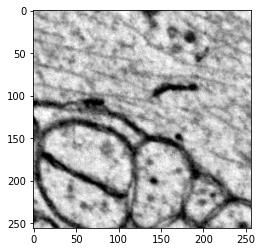

In [4]:
#pick indices/window
window = 256
x_off = 100
y_off = 100
z_off = 10
plt.imshow(data['raw'][z_off, y_off:y_off+window, x_off:x_off+window], cmap='gray')

# Setup Noising Pipeline

In [15]:
noise_batch(samples,
    src_path,
    raw_name,
    noise_dict,
    noise_order,
    src_voxel_size=(40, 4, 4),
    check_every=250,
    scan_size=(40, 512, 512)
    )

Starting /n/groups/htem/ESRF_id16a/tomo_ML/synapse/cb2/volumes/ml0/ml0.zarr/volumes...


### Test pipeline before saving:

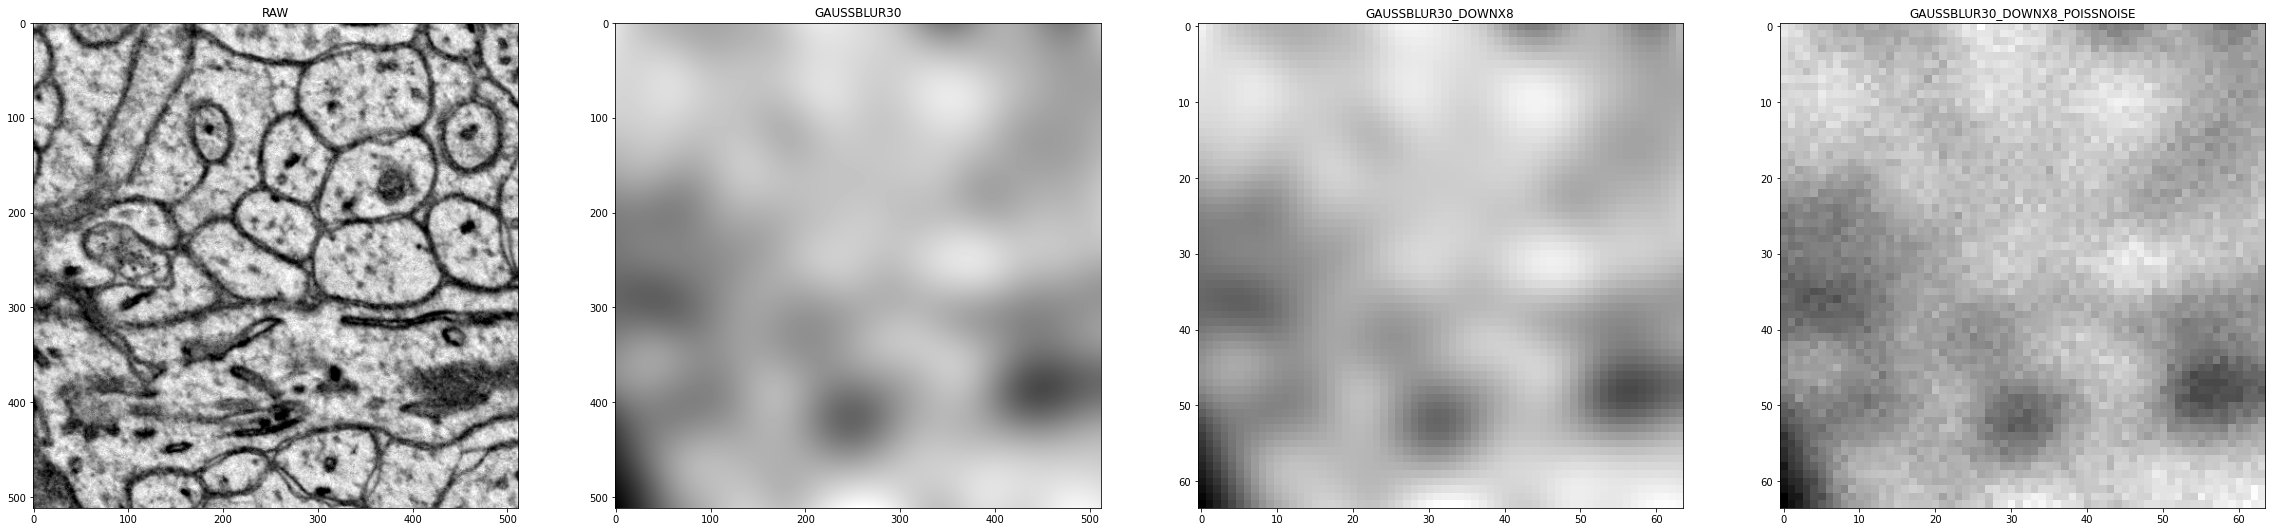

In [3]:
sample = samples[0]
test_batch, arrays = test_noise(sample,
                    src_path,
                    raw_name,
                    noise_dict,
                    noise_order,
                    src_voxel_size=(40, 4, 4),
                    test_size=(40, 2048, 2048)
                    )

In [5]:
#in case you want to check in on the batch outputs:
raw = arrays[0]
noisy = arrays[-1]
test_batch[noisy]

ROI: [0:40, 0:2048, 0:2048] (40, 2048, 2048), voxel size: (40, 32, 32), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False

### Run actual